<center><h1 style="font-size:2.5vw"> AML Project 1 </h1></center>

---
<div style="display:flex; flex-direction:row; width:35%; justify-content : space-between">
    <div style = "display : flex, flex-direction : column">
        <div><b><font color = "#3285d3">Authors</font></b></div>
        <div><b><font color = "#3285d3">Date</font></b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div>Albert Roathel, Marcel Affi</div>
        <div>April 2021</div>
    </div>
</div>

# Project outline

1. [Preprocessing Datasets](#Preprocessing_Datasets)
2. [Measures of Classification](#measures_of_classification)
3. [Optimization Algorithms](#optimization_algorithms)
4. [Experiments](#experiments)

<a id='Preprocessing_Datasets'></a>
## Preprocessing Datasets

We chose to work with the following datasets, each consisting of binary class variables : 
* Diabetes
* Students

TODO: ADD MORE DATASETS

### Downloading the datasets

In [41]:
%%capture --no-stderr

# Students.csv
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
!unzip -o student.zip

### Importing libraries

In [205]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Seaborn properties
sns.set(rc={'figure.figsize':(11.7,5), 'figure.dpi':200})

# plotty properties
def show_plot(fig):
    fig.update_layout({
        'plot_bgcolor': 'rgba(10, 10, 10, 0.1)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'xaxis': {
            'showgrid': False,
            'showline': False,
        },
        'yaxis': {
            'showgrid': False,
            'showline': False,
        }
    })
    fig.show()

# Ignore numpy overflow warnings in sigmoid function
np.seterr( over='ignore' );

In [33]:
diabetes = pd.read_csv('diabetes2.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [236]:
def get_radar_plot(df, target_name, category_0_label, category_1_label):
    input_df = df.copy().iloc[:,0:-1]
    
    #Scaling variables
    scaler = MinMaxScaler()
    input_df = pd.DataFrame(scaler.fit_transform(input_df), columns=input_df.columns)

    categories = input_df.columns.to_list()
    means_0 = input_df.loc[df[target_name] == 0].mean().to_list()
    means_1 = input_df.loc[df[target_name] == 1].mean().to_list()

    targets = df.iloc[:, -1]
    fig = go.Figure()
    
    
    fig.add_trace(go.Scatterpolar(
          r=means_1,
          theta=categories,
          fill='toself',
          name=category_1_label,
    ))
    fig.add_trace(go.Scatterpolar(
          r=means_0,
          theta=categories,
          fill='toself',
          name=category_0_label
    ))

    fig.update_layout(

        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.1,
            xanchor="left",
            x=0.375
        ),

      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
      showlegend=True
    )

    fig.show()
get_radar_plot(diabetes, target_name='Outcome', category_0_label = "Is diabetic", category_1_label = "Is not diabetic")

In [36]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [34]:
len(diabetes)

768

In [176]:
# For one hot encoding
#sex_enc = pd.get_dummies(titanic.sex)
#pclass_enc = pd.get_dummies(titanic.pclass)
#parch_enc = pd.get_dummies(titanic.parch)
#input_df = [sex_enc, pclass_enc, parch_enc]
#input_df = pd.concat(input_df)
#diabetes.iloc[:,0:-1]input_df

In [44]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

input_df = trimm_correlated(diabetes.iloc[:,0:-1], 0.2)

In [170]:
y = diabetes.Outcome.values
X = input_df.values

<a id='measures_of_classification'></a>
## Measures of classification

In [57]:
def calculate_scores(y_true, y_pred):
    unique_classes = np.unique(y_true)
    conf_matrix = np.zeros([len(unique_classes), len(unique_classes)])
    conf_matrix[0, 0] = np.sum(y_pred[y_true==0] == 0)
    conf_matrix[1, 1] = np.sum(y_pred[y_true==1] == 1)
    conf_matrix[0, 1] = np.sum(y_pred[y_true==0] == 1)
    conf_matrix[1, 0] = np.sum(y_pred[y_true==1] == 0)
    
    acc = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
    conf_matrix = pd.DataFrame(conf_matrix, columns=["0", "1"])
    return conf_matrix, acc

<a id='optimization_algorithms'></a>
## Optimization Algorithms

In [58]:
# sigmoid function; models the probability in logistic regression
def sigmoid(X, beta):
    exp = np.exp(np.dot(X, -beta))
    return 1 / (1 + exp)

In [59]:
# cost function for log likelihood optimization
def cost_function(X, y, beta):
    return np.dot(X.T, (y - sigmoid(X, beta)))

In [60]:
# gradient descent approach for minimazation
def gradient_descent(X, y, n_iter=1000, l_rate=1e-4):
    N, p = X.shape
    # initial betas
    beta = np.random.randn(p)
    
    for i in range(n_iter):
        cost = cost_function(X, y, beta)
        beta += cost * l_rate
        
    return beta

In [61]:
def SGD(X, y, n_iter=1000, l_rate=1e-4, n_chunk=50):
    N, p = X.shape
    # initial betas
    beta = np.random.randn(p)
    
    for _ in range(n_iter):
        ind = np.arange(N)
        np.random.shuffle(ind)
        for i in range(0, N, n_chunk):
            subset = ind[i:min(i + n_chunk, N) + 1]
            cost = cost_function(X, y, beta)
            update = cost * l_rate
            beta += update
        
    return beta

In [62]:
def IRLS(X, y, n_iter=1000, w_init = 1, d = 0.5, tolerance = 0.001):
    n,p = X.shape
    delta = np.array(np.repeat(d, n)).reshape(1,n)
    w = np.repeat(1, n)
    W = np.diag( w )
    B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
     ( X.T.dot(W).dot(y) ) )
    for _ in range(n_iter):
        _B = B
        _w = abs(y - X.dot(B)).T
        w = float(1)/np.maximum( delta, _w )
        W = np.diag( w[0] )
        B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
         ( X.T.dot(W).dot(y) ) )
        tol = np.sum( abs( B - _B ) ) 
        if tol < tolerance:
            return B
    return B

<a id='experiments'></a>
## Experiments

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [208]:
np.random.seed(500)

beta = gradient_descent(X_train, y_train, l_rate=0.2)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 70.13%


,0,1
0,132.0,19.0
1,50.0,30.0


In [209]:
np.random.seed(500)

beta = SGD(X_train, y_train, l_rate=0.02)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 72.29%


,0,1
0,129.0,22.0
1,42.0,38.0


In [225]:
beta = IRLS(X_train, y_train, d=0.01, tolerance=0.0005)
pred = (sigmoid(X_test, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y_test, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 45.02%


,0,1
0,28.0,123.0
1,4.0,76.0


In [226]:
def performance_over_iterations(X, y, iterations : int, opt_method):
    beta = opt_method(X, y, n_iter = iterations)
    pred = (sigmoid(X_test, beta) > 0.5).astype(int)
    _, acc = calculate_scores(y_test, pred)
    return [iterations,acc]

from_iter, to_iter, step_size = 20, 1020, 10

  0%|          | 0/100 [00:00<?, ?it/s]

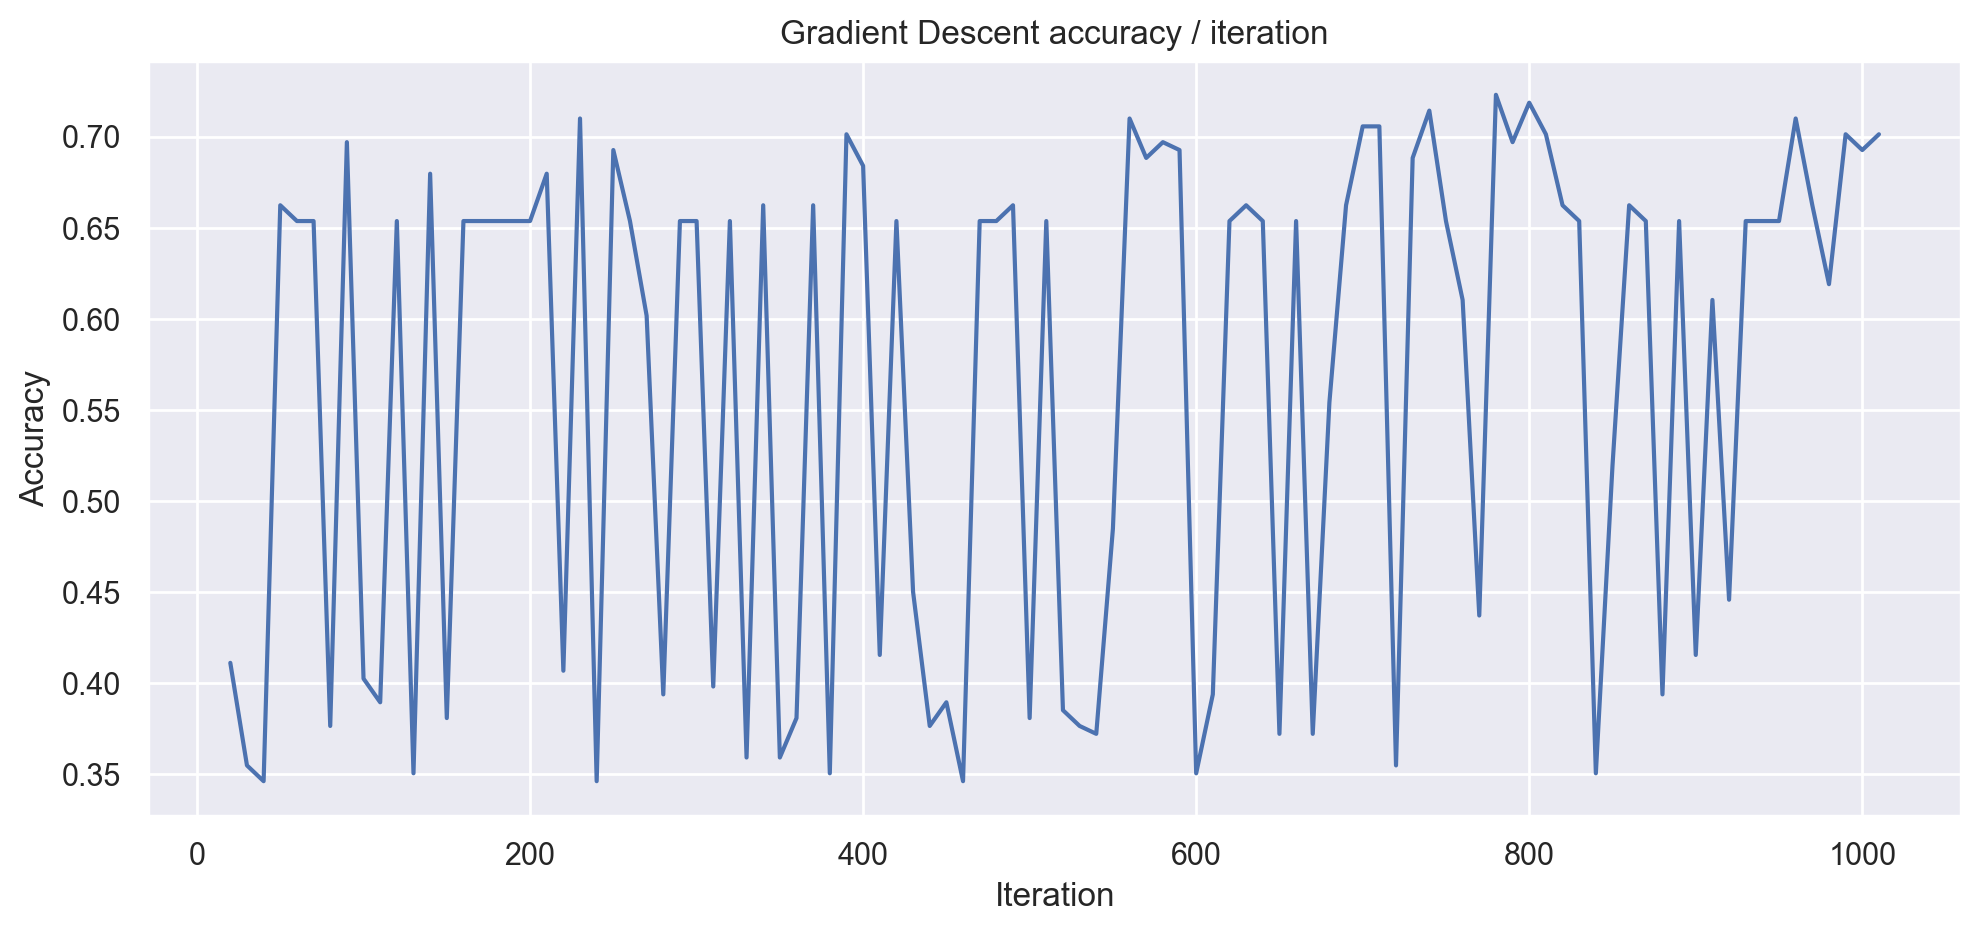

In [227]:
np.random.seed(500)

gd_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, gradient_descent) for iters in tqdm(range(from_iter, to_iter, step_size))]
gd_iter_acc = pd.DataFrame (gd_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= gd_iter_acc, x = "Iteration", y = "Accuracy").set_title("Gradient Descent accuracy / iteration")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

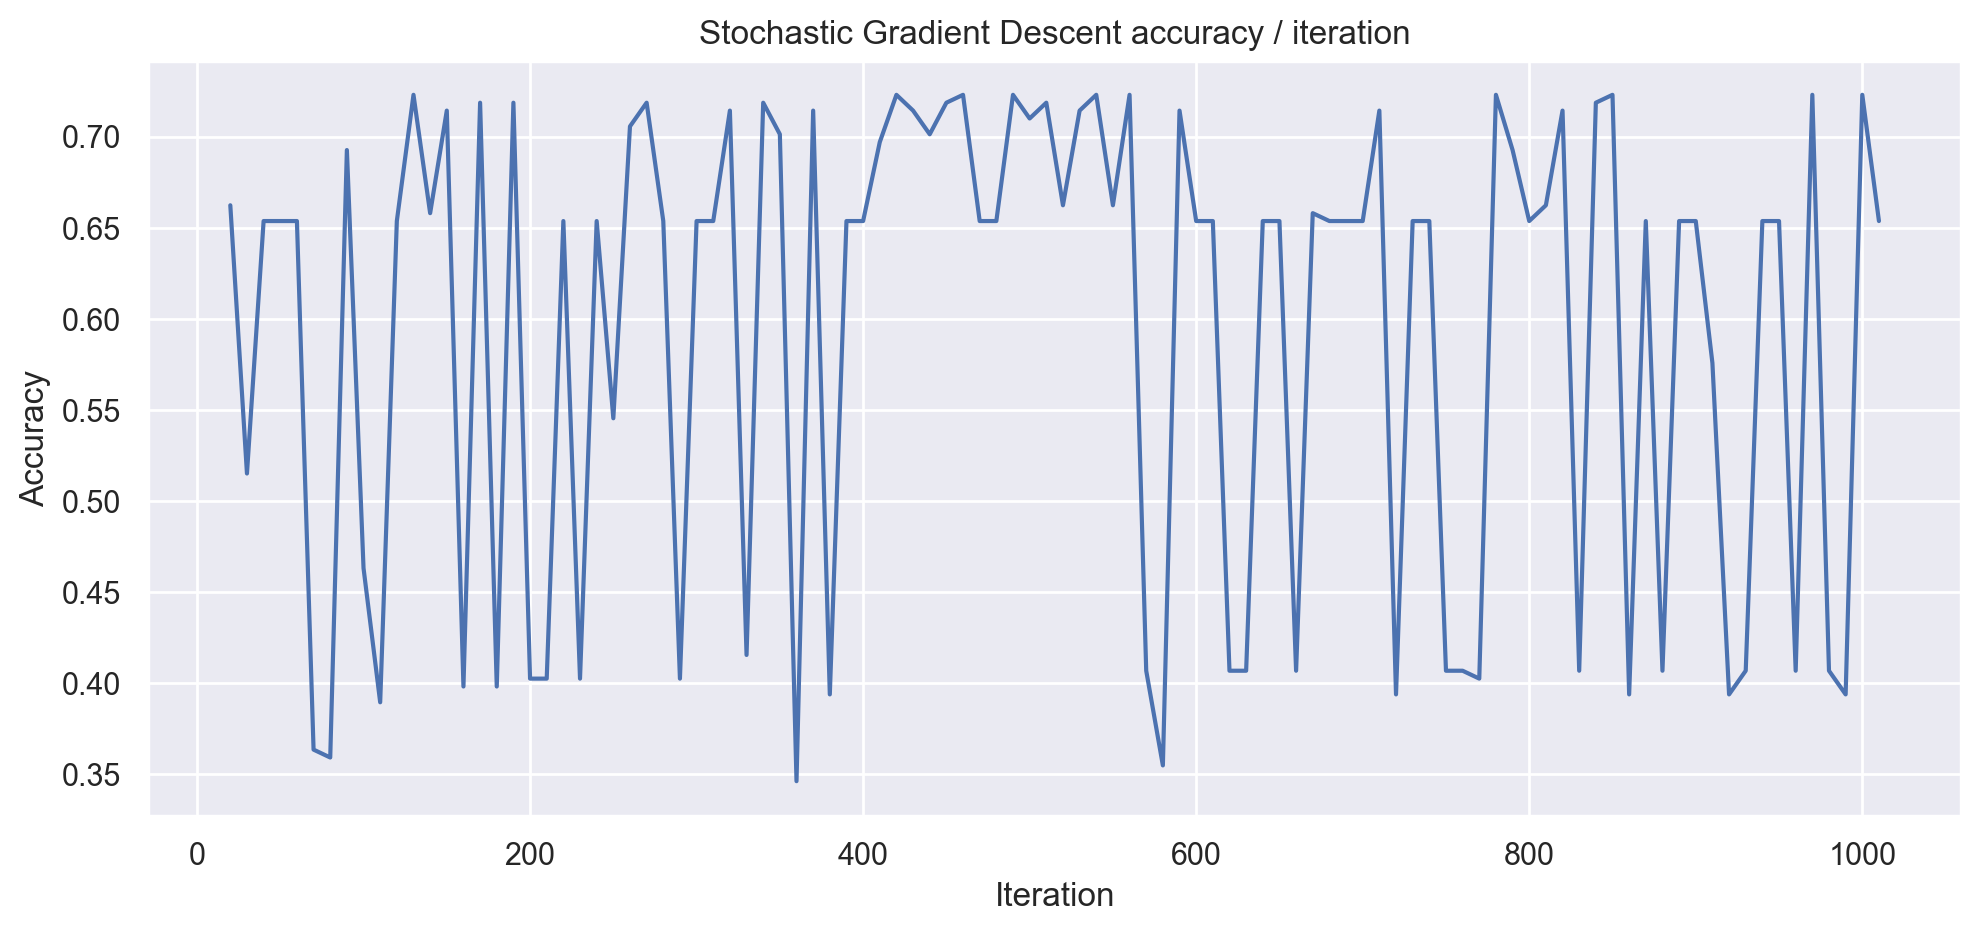

In [228]:
np.random.seed(500)

sgd_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, SGD) for iters in tqdm(range(from_iter, to_iter, step_size))]
sgd_iter_acc = pd.DataFrame (sgd_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= sgd_iter_acc, x = "Iteration", y = "Accuracy").set_title("Stochastic Gradient Descent accuracy / iteration")
plt.show()

# TODO: figure out wtf is going on here xD

  0%|          | 0/100 [00:00<?, ?it/s]

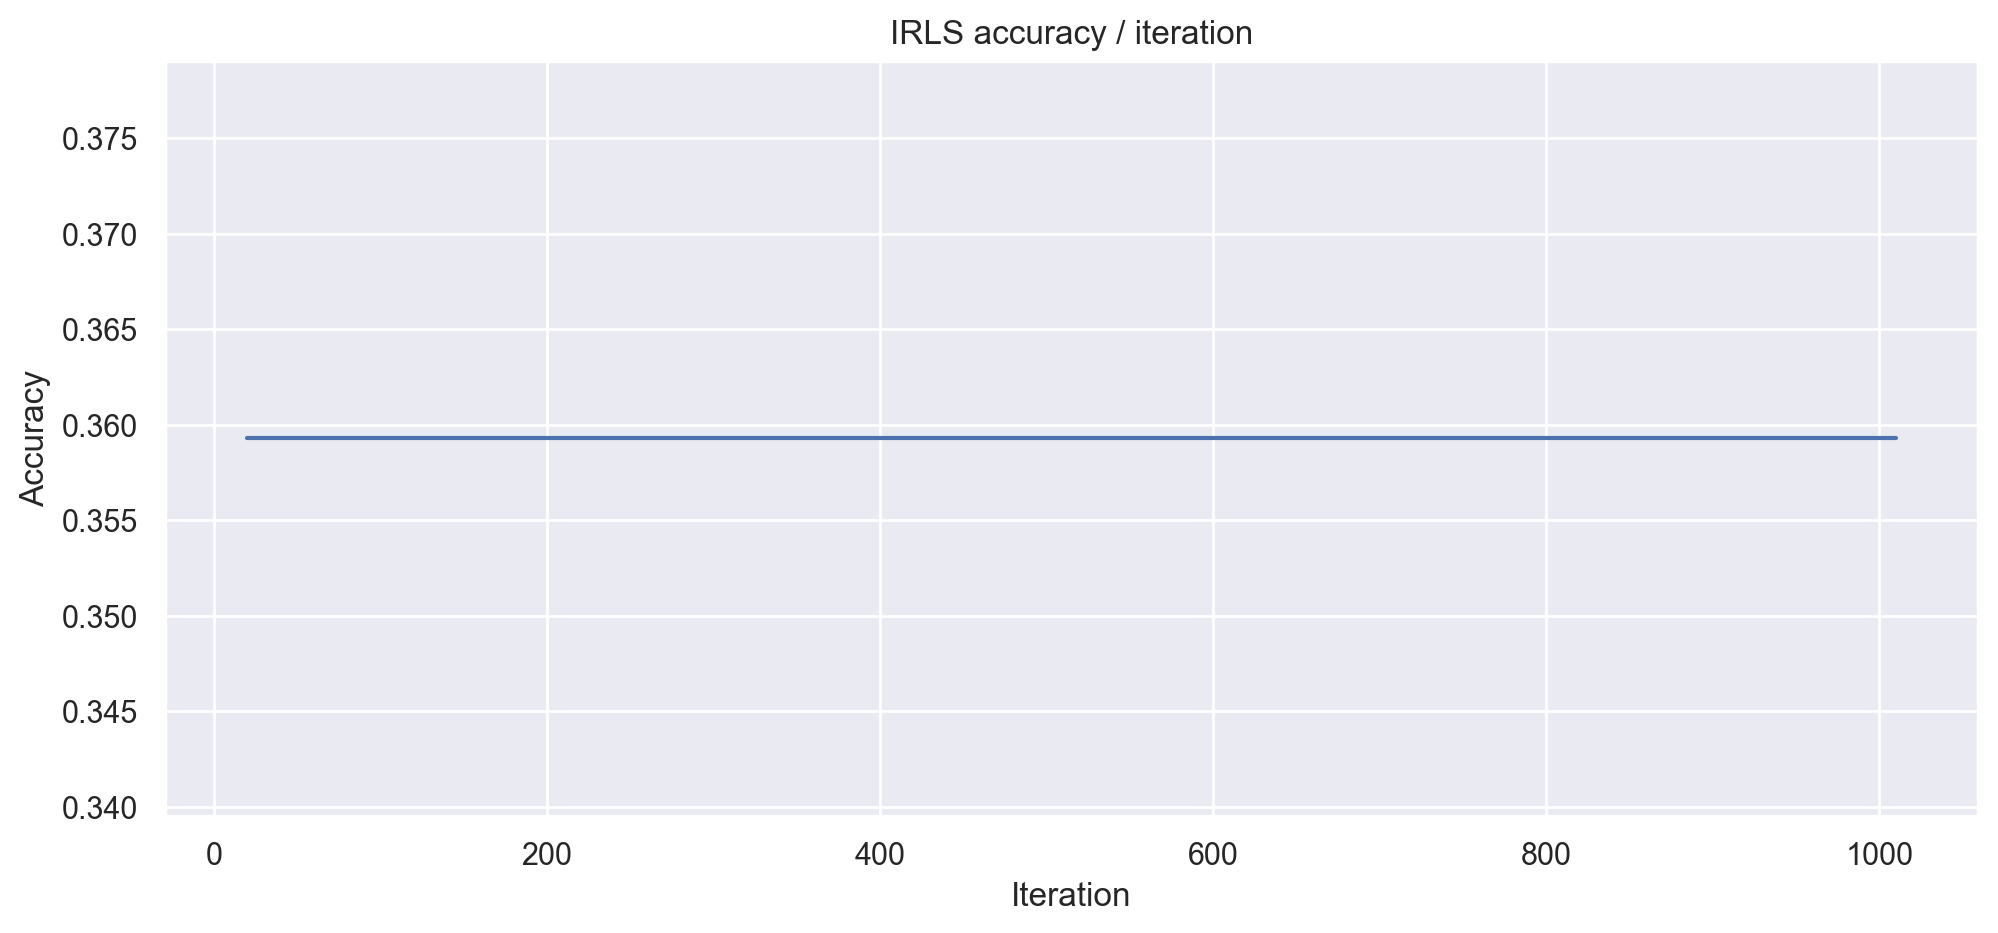

In [230]:
irls_iter_acc_list = [performance_over_iterations(X_train, y_train, iters, IRLS) for iters in tqdm(range(from_iter, to_iter, step_size))]
irls_iter_acc = pd.DataFrame (irls_iter_acc_list,columns=['Iteration', 'Accuracy'])

sns.set_style("darkgrid")
sns.lineplot(data= irls_iter_acc, x = "Iteration", y = "Accuracy").set_title("IRLS accuracy / iteration")
plt.show()

### Testing against other methods form sickit learn

Logistic Regression from sklearn

In [231]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7532467532467533

KNeighborsClassifier from sklearn

In [232]:
nca = NeighborhoodComponentsAnalysis(random_state=42, max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=3)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)
nca_pipe.score(X_test, y_test)

0.7229437229437229

LDA ftom sklearn

In [233]:
clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7532467532467533

QDA from sklearn

In [234]:
clf = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7619047619047619

### Mock data for testing

In [61]:
# lets create simple dataset consiting of N point in R2 that can belong to 2 classes
N = 1000
X = np.random.randn(N * 2).reshape(N, 2) - 1
X[:N//2] = X[:N//2] + 2
y = np.array([0] * (N//2) + [1] * (N//2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y)
show_plot(fig)

In [642]:
# add column of ones to include intercept in the model
intercept = np.ones((X.shape[0], 1))
X = np.concatenate((intercept, X), axis = 1)

In [25]:
beta = gradient_descent(X, y, l_rate=1e-4)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.30%


,0,1
0,456.0,44.0
1,53.0,447.0


In [26]:
beta = SGD(X, y, l_rate=1e-4)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.30%


,0,1
0,456.0,44.0
1,53.0,447.0


In [27]:
# This is low because IRLS is fucking up with the added intercept column, if you remove the intercept
# works as intended, I'll need to check on that maybe tomorrow
beta = IRLS(X, y, n_iter=1000, w_init = 1, d=0.5)
pred = (sigmoid(X, beta) > 0.5).astype(int)
conf_matrix, acc = calculate_scores(y, pred)
print(f'The resulting accuracy is {acc*100:.2f}%')
conf_matrix.head()

The resulting accuracy is 90.40%


,0,1
0,456.0,44.0
1,52.0,448.0


In [646]:
xx = np.linspace(-5, 5, 100)
yy = np.linspace(-5, 5, 100)
xx, yy = np.meshgrid(xx, yy)
xx, yy = xx.flatten(), yy.flatten()
mock_data = np.array([np.ones(len(xx)), xx, yy]).T
values = sigmoid(mock_data, beta)
go.Figure(
    [
        go.Contour(x=xx, y=yy, z=values),
        go.Scatter(x=X[y==0, 1], y=X[y==0, 2], mode='markers', marker_color='red'),
        go.Scatter(x=X[y==1, 1], y=X[y==1, 2], mode='markers', marker_color='blue')
    ],
    layout=dict(
        xaxis=dict(scaleanchor='y', scaleratio=1),
        width=600, height=600,
        showlegend=False
    )
)